# Введение

Готовится к открытию кафе в Москве, в котором гостей должны обслуживать роботы-официанты. Задача состоит в том, чтобы подготовить исследование рынка в виде презентации для инвесторов. Имеются данные о заведениях общественного питания в Москве.

Презентация: https://yadi.sk/i/aVX1x9MhBuEtDw

In [1]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import scipy.stats as stats
import seaborn as sns
from pymystem3 import Mystem
from collections import Counter
import requests
import requests, shutil
import io
from io import BytesIO

# Оглавление  
1. [Подготовка данных к анализу](#1)
2. [Анализ данных](#2)   
    2.1. [Исследование соротношения заведений по типу](#2.1)   
    2.2. [Исследование соотношения сетевых и несетевых заведений по количеству](#2.2)   
    2.3. [Исследование соотношения типа объекта общественного питания и типа распространения (сетевой/несетевой)](#2.3)   
    2.4. [Анализ размеров сетевых заведений](#2.4)  
    2.5. [Анализ среднего количества мест для каждого типа заведения](#2.5)   
    2.6. [Выделение 10 улиц с наибольшим количеством заведений общественного питания](#2.6)   
    2.7. [Загрузка внешнего файла со справочной информацией по улицам и районам г. Москвы](#2.7)   
    2.8. [Оценка распределения количества посадочных мест для улиц с большим количеством заведений общественного питания](#2.8)
3. [Вывод](#solution)

# 1. Подготовка данных <a id='1'></a>

In [2]:
df=pd.read_csv('/datasets/rest_data.csv')
display(df.head())
print(df.info())
print(df['object_name'].value_counts().head(20))
print("Таблица содержит {:.0f} дубликатов".format(df.duplicated().sum()))
print("Таблица  без поля id содержит {:.0f} дубликатов".format(df.duplicated(subset=['object_name','chain', 'object_type', 'address','number']).sum()))
print(len(df['object_name'].unique()))
df.drop_duplicates(subset=['object_name','chain', 'object_type', 'address','number'])

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB
None
Столовая                    267
Кафе                        236
Шаурма                      234
KFC                         155
Шоколадница                 142
Бургер Кинг                 122
Макдоналдс                  122
Домино'с Пицца               86
Теремок                      84
Крошка Картошка              82
Пекарня                      76
Милти                        65
Суши Wok                     61
Буфет                        59
СТОЛОВАЯ                     52
Папа Джонс                   50
Кофе с собой                 44
Школьно-базовая столовая     44
Чайхона №1                   42
КАФЕ   

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
...,...,...,...,...,...,...
15361,208537,Шоколадница,да,кафе,"город Москва, 3-й Крутицкий переулок, дом 18",50
15362,209264,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",10
15363,209186,Шоколадница,да,кафе,"город Москва, улица Земляной Вал, дом 33",20
15364,221900,Шоколадница,да,кафе,"город Москва, поселение Московский, Киевское ш...",36


Таблица содержит 15366 строк и 6 столбцов. В таблице пропущенных значений не найдено. Т.к. id присваивался автоматически и не мог дублироваться, то поиск дубликатов по остальным столбцам, которые заполнялись вручную, выдал наличие 8 дубликатов, которые были удалены.

In [3]:
#замена ё на е, чтобы исключить разные варианты написания
df['object_name']=df['object_name'].str.replace('ё', 'е')
#перевод всех букв в названиях заведений в нижний  регистр
df['object_name'] = df['object_name'].str.lower()
#лемматизация для выявления вариантов написания
m = Mystem()
lemmas=[]
for i in range(df.shape[0]):
    lemmas += m.lemmatize(df['object_name'][i])
print(Counter(lemmas).most_common(20))

print(len(df['object_name'].unique()))
#print(df['object_name'].unique())
print(df['object_name'].value_counts())
#словарь синонимов
synonyms={'McDonalds':['макдоналдс','ресторан "макдоналдс"'], 'KFC':['ресторан "kfc"', 'кфц'], 
          'BurgerKing':['бургеркинг', 'бургер кинг', 'burger king', 'burgerking'], 
          'starbucks':['старбакс','starbucks'], 'subway':['subway','сабвей'],'суши wok':['sushi wok', 'суши wok', 'суши вок']}
def check_synonyms(cell):
    for name, syn in synonyms.items():
        if cell in syn: return name
    return cell
df['object_name_new']=df['object_name'].apply(check_synonyms)
#df[['object_name','object_name_new']].query('object_name_new=="McDonalds"').tail()
print(len(df['object_name_new'].unique()))
#lemmas_new=[]
#for i in range(df.shape[0]):
#    lemmas_new += m.lemmatize(df['object_name_new'][i])
#print(Counter(lemmas_new).most_common(200))

[(' ', 15047), ('\n', 12868), (' «', 2396), ('»\n', 2338), ('кафе', 1844), ('столовая', 1597), ('-', 964), ('школа', 929), ('№', 884), ('.', 733), ('ресторан', 608), ('при', 603), ('гбоу', 469), ('бар', 460), ('пицца', 382), ('шаурма', 360), ('буфет', 327), ('суша', 275), ('кофе', 260), ('пекарня', 253)]
9923
столовая                321
кафе                    278
шаурма                  250
шоколадница             158
kfc                     155
                       ... 
альбион                   1
кафе «марков дворик»      1
котлета                   1
fusion menu               1
regent                    1
Name: object_name, Length: 9923, dtype: int64
9919


В столбце object_name (название объекта общественного питания) произведены замены буквы ё на букву е и все строки были преведены в нижний регистр, чтобы исключить разные варианты написания и дублирования типа "ШОКОЛАДНИЦА" и "шоколадница". Была применена лемматизация для выявления вариантов написания, составлен словарь синонимов. Отредактированные названия были выведены в столбец 'object_name_new'.

# 2. Анализ данных <a id='2'></a>

#### Исследование соотношения заведений по типу <a id='2.1'></a>

object_type
бар                                   856
буфет                                 585
закусочная                            360
кафе                                 6099
кафетерий                             398
магазин (отдел кулинарии)             273
предприятие быстрого обслуживания    1923
ресторан                             2285
столовая                             2587
Name: object_type, dtype: int64


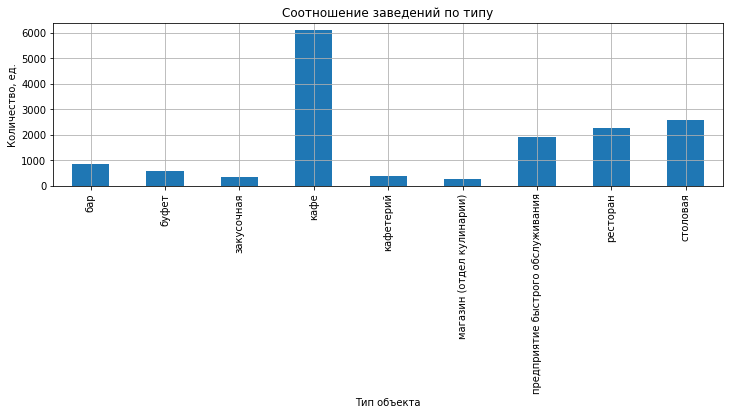

In [4]:
df_type=df.groupby('object_type')['object_type'].count()
df_type.columns=[['type','amount']]
print(df_type)
fig, ax = plt.subplots(figsize=(12, 3))
df_type.plot(kind='bar')
plt.title("Соотношение заведений по типу")
plt.xlabel("Тип объекта")
plt.ylabel("Количество, ед.")
ax.yaxis.grid(True) 
ax.xaxis.grid(True) 
plt.show()

Представленный график демонтрирует, что в г. Москва наибольшее количество объектов общественного питания типа "кафе", на 2 месте - "столовая", на 3м месте - "ресторан", на 4м месте - "предприятие общественного питания". Остальных типов ("бар", "буфет", "закусочная", "кафетерий", "магазин(отдел кулинарии)") - значительно меньше.

#### Исследование соотношения сетевых и несетевых заведений по количеству <a id='2.2'></a>

Несетевых заведений 80.68%
Cетевых заведений 19.32%


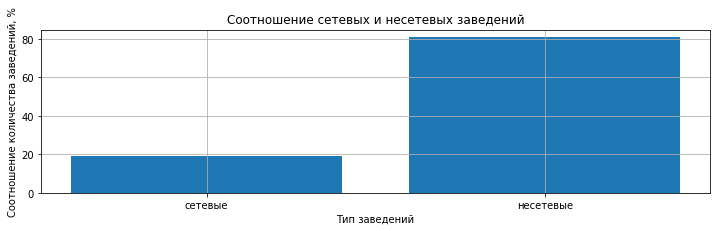

In [5]:
df_chain=df.query('chain=="да"')
chain=100*len(df_chain)/len(df)
df_notChain=df.query('chain=="нет"')
notChain=100*len(df_notChain)/len(df)
print("Несетевых заведений {:.2f}%".format(notChain))
print("Cетевых заведений {:.2f}%".format(chain))
keys=['сетевые', 'несетевые']
vals=[chain, notChain]
fig, ax = plt.subplots(figsize=(12, 3))
plt.bar(keys,vals)
plt.title("Соотношение сетевых и несетевых заведений")
plt.ylabel("Соотношение количества заведений, %")
plt.xlabel("Тип заведений")
ax.yaxis.grid(True) 
ax.xaxis.grid(True) 
plt.show()

График демонстрирует, что несетевые заведения составляют около 81% от общего количества заведений, а сетевые заведения - около 19% от общего количества.

#### Исследование соотношения типа объекта общественного питания и типа распространения (сетевой/несетевой) <a id='2.3'></a>

                                   chain  no_chain    chain,%  no_chain,%
object_type                                                              
бар                                   37       819   4.322430   95.677570
буфет                                 11       574   1.880342   98.119658
закусочная                            56       304  15.555556   84.444444
кафе                                1396      4703  22.888998   77.111002
кафетерий                             52       346  13.065327   86.934673
магазин (отдел кулинарии)             78       195  28.571429   71.428571
предприятие быстрого обслуживания    791      1132  41.133645   58.866355
ресторан                             544      1741  23.807440   76.192560
столовая                               3      2584   0.115964   99.884036


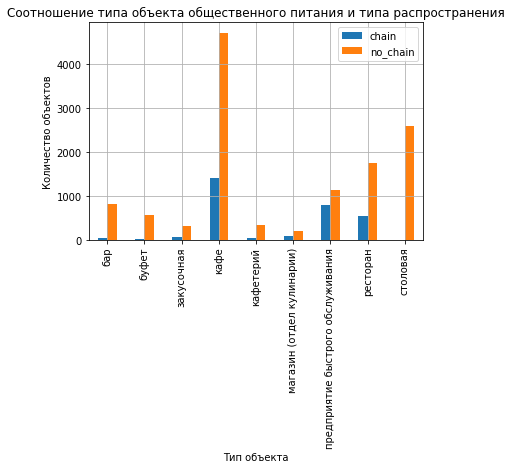

In [6]:
df33=df.pivot_table(index='chain', columns='object_type',values='id', aggfunc='count')
df33=df33.T
df33.columns=['chain','no_chain']
df33['chain,%']=100*df33['chain']/(df33['chain']+df33['no_chain'])
df33['no_chain,%']=100*df33['no_chain']/(df33['chain']+df33['no_chain'])
print(df33)
df34=df33[['chain','no_chain']]
df34.plot( kind='bar', grid=True)
plt.title("Соотношение типа объекта общественного питания и типа распространения")
plt.xlabel("Тип объекта")
plt.ylabel("Количество объектов")
plt.show()

Представленный график демонстрирует, что наиболее распространены несетевые заведения. Можно сделать вывод, что наибольшее распространение среди сетевых имеют заведения типов: кафе(1 место), предприятие быстрого питание(2 место), ресторан(3 место).

#### Анализ размеров сетевых заведений <a id='2.4'></a>

шоколадница    157
kfc            155
McDonalds      151
BurgerKing     137
теремок         94
Name: object_name_new, dtype: int64
Index(['шоколадница', 'kfc', 'McDonalds', 'BurgerKing', 'теремок'], dtype='object')
40    50
0     42
30    42
20    41
50    38
Name: number, dtype: int64


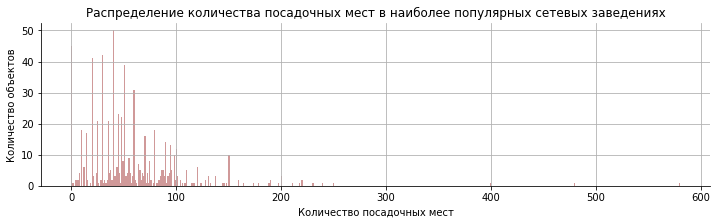

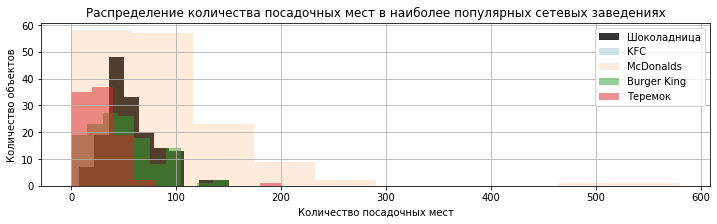

In [7]:
df_chain_top5=df_chain['object_name_new'].value_counts().head()
print(df_chain_top5)
print(df_chain_top5.index)
table_top5=df.query('object_name_new in @df_chain_top5.index')
top5_number=table_top5['number'].value_counts()
print(top5_number.head())
fig, ax = plt.subplots(figsize=(12, 3))
sns.distplot(table_top5['number'],kde = False, bins=500,color='darkred')
plt.xlabel("Количество посадочных мест")
plt.ylabel("Количество объектов")
plt.title("Распределение количества посадочных мест в наиболее популярных сетевых заведениях")
ax.yaxis.grid(True) 
ax.xaxis.grid(True) 
sns.despine()
plt.show()
df_shoko=df.query('object_name_new=="шоколадница"')
df_kfc=df.query('object_name_new=="KFC"')
df_mc=df.query('object_name_new=="McDonalds"')
df_bk=df.query('object_name_new=="BurgerKing"')
df_t=df.query('object_name_new=="теремок"')
fig, ax = plt.subplots(figsize=(12, 3))
df_shoko['number'].hist(label='Шоколадница', alpha=0.8, color='black')
df_kfc['number'].hist(label='KFC', alpha=0.2)
df_mc['number'].hist(label='McDonalds', alpha=0.15)
df_bk['number'].hist(label='Burger King', alpha=0.5)
df_t['number'].hist(label='Теремок', alpha=0.5)
plt.xlabel("Количество посадочных мест")
plt.ylabel("Количество объектов")
plt.title("Распределение количества посадочных мест в наиболее популярных сетевых заведениях")
plt.legend()
plt.show()

Анализ показал, что наибольшее количество заведений с 40, 0, 30 и 20 посадочными местами. Наиболее редко среди сетевых заведений встречаются заведения с 55, и более, чем 70 посадочными местами. Из этого можно сделать вывод, что наиболее характерно для сетевых заведений большое количество со средним количеством посадочным мест, либо без посадочным мест.   
График демонстрирует, что для наиболее распространенных сетевых заведений: KFC, McDonalds, Burger King, Шоколадница и Теремок характерно большое количество заведений с небольшим количеством посадочных мест(до 100 мест). Сеть McDonalds также имеет достаточно большое количество заведений среднего размера(от 100 до 200 посадочных мест). Для сети Шоколадница характерно большое количество заведений с 40-60 посадочными местами. Для сети Теремок характерно большое количество небольших заведений  с количеством посадочных мест от 0 до 40.

#### Анализ среднего количества мест для каждого типа заведения <a id='2.5'></a>

object_type
бар                                  99.500000
буфет                                10.000000
закусочная                           28.818182
кафе                                 52.601626
предприятие быстрого обслуживания    60.997159
ресторан                             55.843373
Name: number, dtype: float64
                                      number
object_type                                 
бар                                99.500000
буфет                              10.000000
закусочная                         28.818182
кафе                               52.601626
предприятие быстрого обслуживания  60.997159


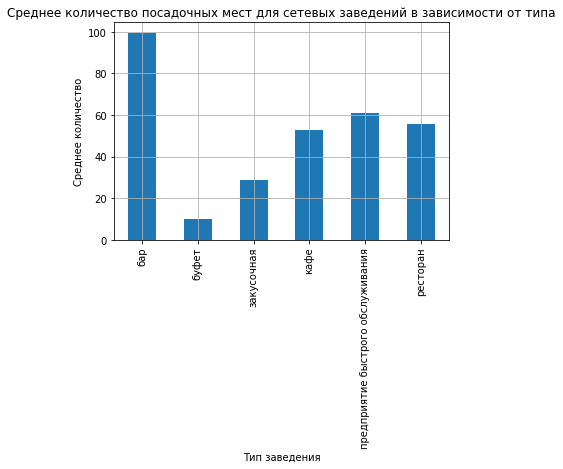

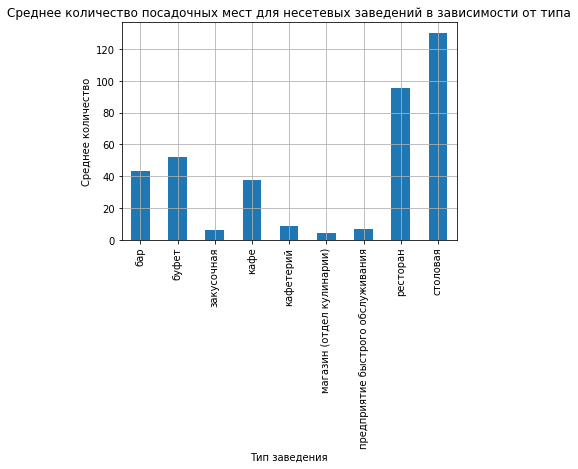

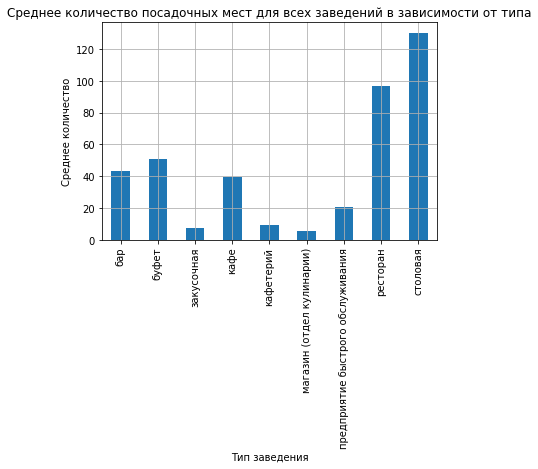

In [8]:
df_chain_type=table_top5.pivot_table(index='object_type', values='number', aggfunc='mean')
df_chain_type1=table_top5.groupby('object_type')['number'].mean()
print(df_chain_type1)
print(df_chain_type.head())
fig, ax = plt.subplots()
df_chain_type1.plot(kind='bar')
plt.title("Среднее количество посадочных мест для сетевых заведений в зависимости от типа")
plt.xlabel("Тип заведения")
plt.ylabel("Среднее количество")
ax.yaxis.grid(True) 
ax.xaxis.grid(True) 
plt.show()
df_not_chain_type=df_notChain.groupby('object_type')['number'].mean()
df_not_chain_type.plot(kind='bar', grid=True)
plt.title("Среднее количество посадочных мест для несетевых заведений в зависимости от типа")
plt.xlabel("Тип заведения")
plt.ylabel("Среднее количество")
plt.show()
df_type_number=df.groupby('object_type')['number'].mean()
df_type_number.plot(kind='bar', grid=True)
plt.title("Среднее количество посадочных мест для всех заведений в зависимости от типа")
plt.xlabel("Тип заведения")
plt.ylabel("Среднее количество")
plt.show()

Анализ показал, что среди сетевых заведений для баров храктерно наибольшее количество посадочных мест (в среднем - 99,5), а для сетевых буфетов - минимальное(в среднем - 10). Анализ посадочных мест несетевых и всех заведений показал, что наибольшее количество посадочных мест характерно для столовых и ресторанов.

#### Выделение улицы расположения заведения в отдельный столбец

In [9]:
df['street']=df['address'].str.extract(
    '(([А-я0-9\-\s]+)?(улица|деревня|мост|Зеленоград|автодороги|просек|Горы|дороги|переулок|парк|посёлок|поселение|поселок|бульвар|шоссе|площадь|проспект|проезд|проектируемый проезд|просека|бульвар|набережная|микрорайон|аллея|квартал|линия|тупик)([А-я0-9\s]+)?)')[0]
df['street']=df['street'].str.strip()
df.head(20)


,id,object_name,chain,object_type,address,number,object_name_new,street
0,151635,сметана,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,сметана,улица Егора Абакумова
1,77874,родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,родник,улица Талалихина
2,24309,кафе «академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,кафе «академия»,Абельмановская улица
3,21894,пиццетория,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,пиццетория,Абрамцевская улица
4,119365,кафе «вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,кафе «вишневая метель»,Абрамцевская улица
5,27429,стол. при гоу сош № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корп...",240,стол. при гоу сош № 1051,Абрамцевская улица
6,148815,брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10,брусника,переулок Сивцев Вражек
7,20957,буфет мтуси,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",90,буфет мтуси,Авиамоторная улица
8,20958,кпф семья-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",150,кпф семья-1,Авиамоторная улица
9,28858,столовая мтуси,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",120,столовая мтуси,Авиамоторная улица


Улицы выделены в отдельный столбец 'street'.

In [10]:
print(len(df['street'].unique()))
print(df['street'].value_counts())
display(df.sort_values(by='street', ascending=True),pd.set_option('display.max_columns', None))
print(df.info(),pd.set_option('display.max_columns', None))

1849
город Зеленоград          232
проспект Мира             204
Профсоюзная улица         183
Ленинградский проспект    173
Пресненская набережная    167
                         ... 
Минаевский переулок         1
Богоявленский переулок      1
улица Капотня               1
улица Паперника             1
Изваринская улица           1
Name: street, Length: 1849, dtype: int64


,id,object_name,chain,object_type,address,number,object_name_new,street
7465,152594,бар «боливар»,нет,ресторан,"город Москва, 1-й Автозаводский проезд, дом 4,...",90,бар «боливар»,1-й Автозаводский проезд
12685,200076,чайхана элина,нет,кафе,"город Москва, 1-й Автозаводский проезд, дом 5",20,чайхана элина,1-й Автозаводский проезд
10951,184872,пекарня,нет,кафетерий,"город Москва, 1-й Автозаводский проезд, дом 5",4,пекарня,1-й Автозаводский проезд
7066,82610,столовая театрального колледжа,нет,столовая,"город Москва, 1-й Амбулаторный проезд, дом 2, ...",40,столовая театрального колледжа,1-й Амбулаторный проезд
2952,27410,колледж автомобильного транспорта № 9,нет,столовая,"город Москва, 1-й Амбулаторный проезд, дом 8, ...",100,колледж автомобильного транспорта № 9,1-й Амбулаторный проезд
...,...,...,...,...,...,...,...,...
3948,27490,столовая гбоу школа № 922,нет,столовая,"город Москва, шоссе Энтузиастов, дом 100А",240,столовая гбоу школа № 922,шоссе Энтузиастов
3956,21450,буфет при школе № 443,нет,буфет,"город Москва, шоссе Энтузиастов, дом 72",40,буфет при школе № 443,шоссе Энтузиастов
15138,223224,yogurt frenzy,да,закусочная,"город Москва, шоссе Энтузиастов, дом 12, корпус 2",0,yogurt frenzy,шоссе Энтузиастов
1385,124807,кулинария пан пан,нет,магазин (отдел кулинарии),"город Москва, шоссе Энтузиастов, дом 74/2",6,кулинария пан пан,шоссе Энтузиастов


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 8 columns):
id                 15366 non-null int64
object_name        15366 non-null object
chain              15366 non-null object
object_type        15366 non-null object
address            15366 non-null object
number             15366 non-null int64
object_name_new    15366 non-null object
street             15366 non-null object
dtypes: int64(2), object(6)
memory usage: 960.5+ KB
None None


#### Выделение 10 улиц с наибольшим количеством заведений общественного питания

In [11]:
top10_street=df['street'].value_counts().head(10)
print(top10_street)

город Зеленоград          232
проспект Мира             204
Профсоюзная улица         183
Ленинградский проспект    173
Пресненская набережная    167
Варшавское шоссе          164
Ленинский проспект        148
поселение Сосенское       139
проспект Вернадского      132
Кутузовский проспект      114
Name: street, dtype: int64


#### Загрузка внешнего файла со справочной информацией по улицам и районам г. Москвы <a id='2.7'></a>

In [12]:
spreadsheet_id = '1aWEDFdFE8lGpj3khk0sZmv-7pEgV-uygcGIbxSkloNA'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
streets_list = pd.read_csv(BytesIO(r.content))
display(streets_list)

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район
...,...,...,...,...
4393,Вознесенский проезд,17,ЦАО,Пресненский район
4394,Волков переулок,17,ЦАО,Пресненский район
4395,Поварская улица,17,ЦАО,Пресненский район
4396,Кудринская площадь,17,ЦАО,Пресненский район


count
streetname             okrug            
Варшавское шоссе       ЮАО             6
                       ЮЗАО            2
Кутузовский проспект   ЗАО             2
Ленинградский проспект САО             4
Ленинский проспект     ЗАО             2
                       ЦАО             1
                       ЮАО             1
                       ЮЗАО            4
Пресненская набережная ЦАО             1
Профсоюзная улица      ЮЗАО            6
город Зеленоград       Зеленоград      3
проспект Вернадского   ЗАО             3
                       ЮЗАО            2
проспект Мира          СВАО            6
                       ЦАО             1

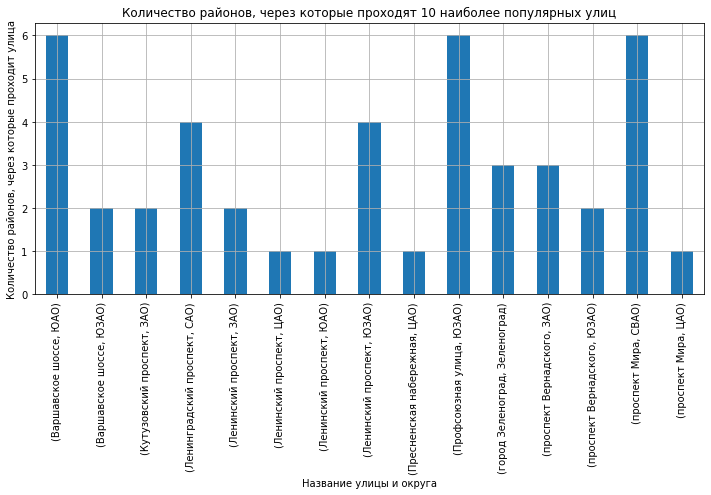

         streetname  areaid okrug                area
2293  проспект Мира      70  СВАО  Алексеевский район
2390  проспект Мира      86  СВАО   Ярославский Район
2531  проспект Мира      78  СВАО  Район Марьина роща
2578  проспект Мира      79  СВАО  Останкинский район
2644  проспект Мира      81  СВАО     Район Ростокино
2712  проспект Мира      82  СВАО      Район Свиблово
4334  проспект Мира      16   ЦАО     Мещанский район


In [13]:
str_mir=streets_list.query('streetname in @top10_street.index')
street_pivot_table1=str_mir.pivot_table(index=['streetname', 'okrug'], values='area', aggfunc={'count'})
#street_pivot_table1.columns=['amount']
street_pivot_table=str_mir.groupby(['streetname', 'okrug'])['area'].count()
street_pivot_table=street_pivot_table.T
display(street_pivot_table1)
fig, ax = plt.subplots()
street_pivot_table.plot(kind='bar', grid=True, figsize=(12,5))
plt.xlabel("Название улицы и округа")
plt.ylabel("Количество районов, через которые проходит улица")
plt.title("Количество районов, через которые проходят 10 наиболее популярных улиц")
plt.show()
print(streets_list.query('streetname =="проспект Мира"'))

Многие улицы из списка топ-10 проходят через несколько районов и административных округов. Для простоты анализа для каждой улицы следует выделить округ в котором данная улица проходит по бОльшему количеству районов. Например, проспект Мира расположен в районах Алексеевский, Марьина роща, Мещанский, Останкинский, Ростокино, Свиблово и Ярославский на территории Северо-Восточного административного округа и Центрального административного округа города Москвы. Проспект Мира в  Северо-Восточном административном округе проходит через 6 районов, а в Центральном административном округе - через 1. Тогда примем, что проспект Мира принадлежит Северо-Восточному административному округу. Аналогично: Варшавское шоссе, Каширское шоссе и Кировоградская улица - Южный автономный округ, Ленинский проспект и Профсоюзная улица - Юго-Западный автономный округ, Кутузовский проспект и проспект Вернадского - Западный автономный округ, Ленинградский проспект - Северный автономный округ, Пресненская набережная - Центральный автономный округ.
Можно сделать вывод, что улицы с наибольшим количеством заведений общественнго питания расположены преимущественно на территории Южного, Юго-Западного административных округов.

#### Выделение улиц с одним объектом общественного питания

In [14]:
#группировка улиц по количеству заведений на них
empty=df.pivot_table(columns='street', values='id', aggfunc='count')
empty=empty.T
empty.columns=['amount']
#выделение в отдельный датафрейм записей об улицах, на которых 1 заведение
empty_street_list=empty.query('amount==1')
#выделение в отдельный датафрейм записей из внешнего источника об улицах, названия которых содержатся в датафрейме empty_street_list
str_empty=streets_list.query('streetname in @empty_street_list.index')
print(len(empty_street_list), "улиц с одним объектом общественного питания в Москве")
display(str_empty['area'].unique())
display(str_empty['okrug'].unique())

530 улиц с одним объектом общественного питания в Москве


array(['Пресненский район', 'Таганский район', 'Тверской район',
       'Район Арбат', 'Район Замоскворечье', 'Район Богородское',
       'Район Гольяново', 'Район Измайлово', 'Район Косино-Ухтомский',
       'Басманный район', 'Район Метрогородок', 'Район Новогиреево',
       'Район Перово', 'Район Преображенское', 'Район Северное Измайлово',
       'Район Соколиная Гора', 'Район Восточное Измайлово',
       'Район Восточный', 'Район Ивановское', 'Район Сокольники',
       'Район Дорогомилово', 'Район Фили-Давыдково', 'Район Кунцево',
       'Можайский Район', 'Район Ново-Переделкино',
       'Район Очаково-Матвеевское', 'Район Раменки', 'Район Солнцево',
       'Район Внуково', 'Район Крюково', 'Район Матушкино-Савелки',
       'Район Аэропорт', 'Район Беговой', 'Бескудниковский Район',
       'Дмитровский район', 'Головинский район', 'Хорошевский район',
       'Район Коптево', 'Район Левобережный', 'Молжаниновский район',
       'Савеловский район', 'Район Сокол', 'Тимирязевский Ра

array(['ЦАО', 'ВАО', 'ЗАО', 'Зеленоград', 'САО', 'СВАО', 'СЗАО', 'ЮАО',
       'ЮВАО', 'ЮЗАО'], dtype=object)

Анализ показал, что в г. Москва 530 улиц с одним объектом общественного питания. Из внешнего открытого источника было найдено, что эти улицы располагаются в следующих районах: 'Пресненский район', 'Таганский район', 'Тверской район', 'Район Арбат','Район Замоскворечье', 'Район Богородское', 'Район Гольяново', 'Район Измайлово', 'Район Косино-Ухтомский', 'Басманный район', 'Район Метрогородок', 'Район Новогиреево', 'Район Перово', 'Район Преображенское', 'Район Северное Измайлово', 'Район Соколиная Гора', 'Район Восточное Измайлово', 'Район Восточный', 'Район Ивановское', 'Район Сокольники', 'Район Дорогомилово', 'Район Фили-Давыдково', 'Район Кунцево', 'Можайский Район', 'Район Ново-Переделкино', 'Район Очаково-Матвеевское', 'Район Раменки', 'Район Солнцево', 'Район Внуково', 'Район Крюково', 'Район Матушкино-Савелки', 'Район Аэропорт', 'Район Беговой', 'Бескудниковский Район', 'Дмитровский район', 'Головинский район', 'Хорошевский район', 'Район Коптево', 'Район Левобережный', 'Молжаниновский район', 'Савеловский район', 'Район Сокол', 'Тимирязевский Район', 'Войковский Район', 'Район Западное Дегунино', 'Алексеевский район', 'Алтуфьевский район', 'Бабушкинский район', 'Бутырский район', 'Ярославский Район', 'Район Южное Медведково', 'Район Лианозово', 'Район Хамовники', 'Лосиноостровский район', 'Район Марфино', 'Район Марьина роща', 'Останкинский район', 'Район Отрадное', 'Район Ростокино', 'Район Северное Медведково', 'Район Северный', 'Район Свиблово', 'Район Хорошево-Мневники', 'Район Куркино', 'Район Митино', 'Район Покровское-Стрешнево', 'Район Щукино', 'Район Строгино', 'Район Южное Тушино', 'Район Бирюлево Восточное', 'Район Царицыно', 'Район Чертаново Северное', 'Район Чертаново Южное', 'Даниловский район', 'Донской район', 'Район Москворечье-Сабурово', 'Район Нагатино-Садовники', 'Нагорный район', 'Южнопортовый Район', 'Район Кузьминки', 'Район Лефортово', 'Район Люблино', 'Район Марьино', 'Нижегородский район', 'Район Печатники', 'Рязанский район', 'Район Текстильщики', 'Район Выхино-Жулебино', 'Район Черемушки', 'Район Ясенево', 'Район Коньково', 'Район Котловка', 'Район Якиманка', 'Обручевский район', 'Район Северное Бутово', 'Район Зюзино', 'Район Южное Бутово', 'Красносельский район', 'Мещанский район'.

#### Оценка распределения количества посадочных мест для улиц с большим количеством объектов общественного питания <a id='2.8'></a>

In [15]:
df_top10_street=df.query('street in @top10_street.index')
display(df_top10_street.head())

,id,object_name,chain,object_type,address,number,object_name_new,street
151,155973,кафе «андерсон»,да,кафе,"город Москва, Варшавское шоссе, дом 2",150,кафе «андерсон»,Варшавское шоссе
152,23618,кафе «subway»,да,кафе,"город Москва, Варшавское шоссе, дом 7, корпус 1",36,кафе «subway»,Варшавское шоссе
153,155852,кафе «ламаджо»,нет,кафе,"город Москва, Варшавское шоссе, дом 29",30,кафе «ламаджо»,Варшавское шоссе
154,152556,шаурма в пите,нет,предприятие быстрого обслуживания,"город Москва, Варшавское шоссе, дом 72, корпус 2",0,шаурма в пите,Варшавское шоссе
155,120658,выпечка,нет,кафетерий,"город Москва, Варшавское шоссе, дом 100",2,выпечка,Варшавское шоссе


street
Варшавское шоссе          164
Кутузовский проспект      114
Ленинградский проспект    173
Ленинский проспект        148
Пресненская набережная    167
Профсоюзная улица         183
город Зеленоград          232
поселение Сосенское       139
проспект Вернадского      132
проспект Мира             204
Name: number, dtype: int64
street
Варшавское шоссе          164
Кутузовский проспект      114
Ленинградский проспект    173
Ленинский проспект        148
Пресненская набережная    167
Профсоюзная улица         183
город Зеленоград          232
поселение Сосенское       139
проспект Вернадского      132
проспект Мира             204
Name: number, dtype: int64


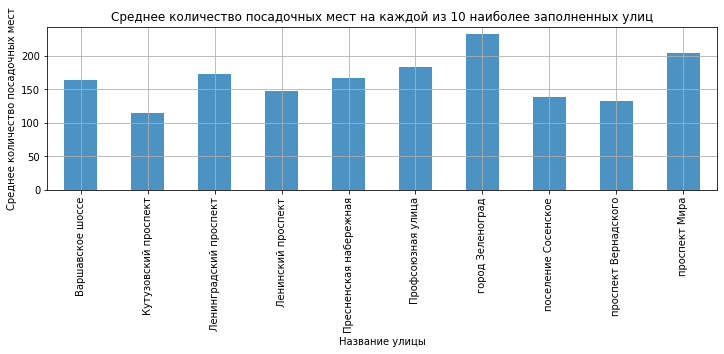

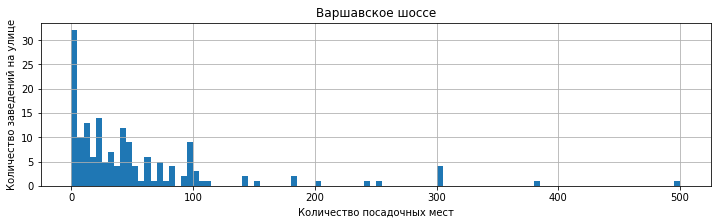

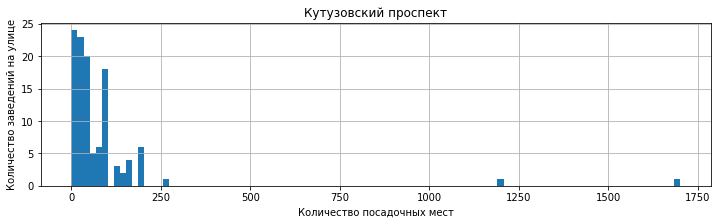

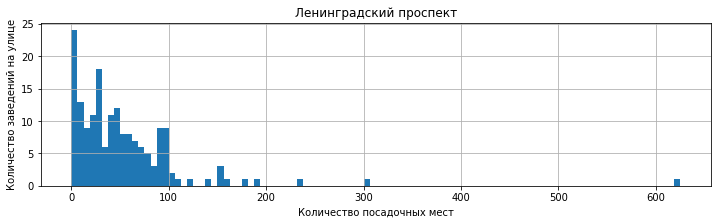

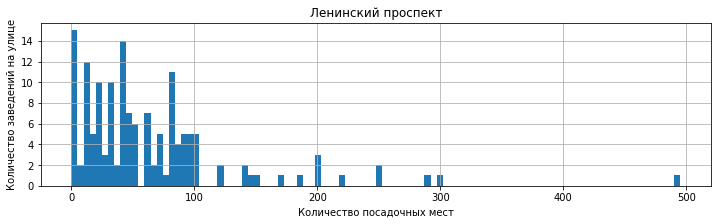

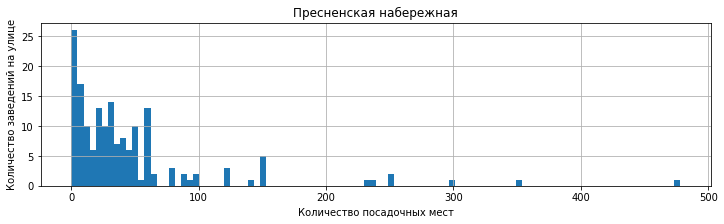

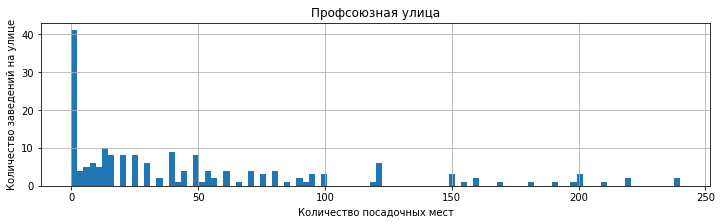

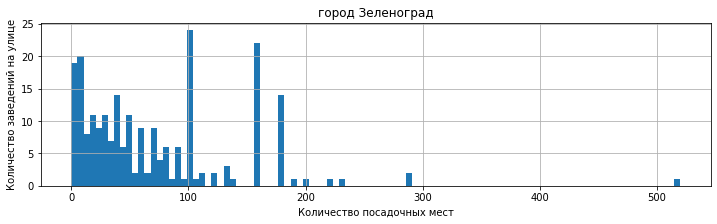

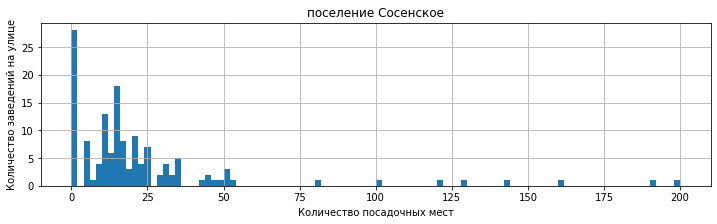

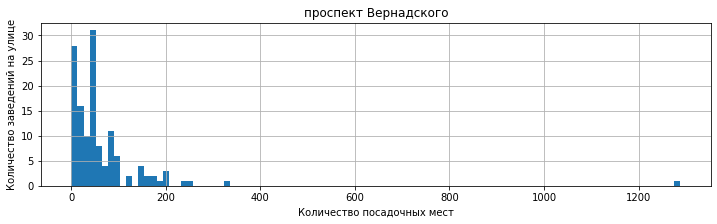

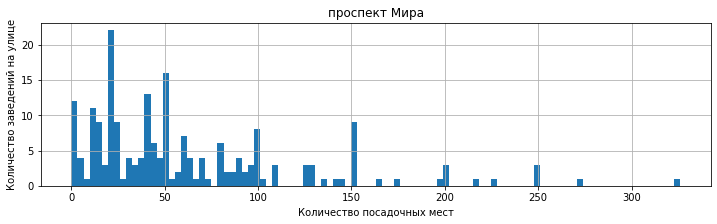

In [16]:
print(df_top10_street.groupby('street')['number'].count())
table_top10_street=df_top10_street.groupby('street')['number'].count()
print(table_top10_street)
fig, ax = plt.subplots(figsize=(12, 3))
table_top10_street.plot(kind='bar',alpha=0.8)
plt.xlabel("Название улицы")
plt.ylabel("Среднее количество посадочных мест")
plt.title("Среднее количество посадочных мест на каждой из 10 наиболее заполненных улиц")
ax.yaxis.grid(True) 
ax.xaxis.grid(True) 
plt.show()
df_test=df_top10_street[['street','number']]
for name, test in df_test.groupby('street'):
    test.hist(figsize=(12, 3),bins=100)
    plt.title(name)
    plt.xlabel("Количество посадочных мест")
    plt.ylabel("Количество заведений на улице")
    plt.show()

Представленные графики демонстрируют, что, в среднем, наибольшее количество посадочных мест в заведениях, расположенных на проспекте Мира, на Профсоюзной улице и на Ленинградском проспекте. Большое количество маленьких заведений (без посадочных мест) характерно для Варшавского шоссе, Каширского шоссе, Кировоградской улицы, Пресненской набережной. Для Кутузовского проспекта характерно наличие большого количества маленьких заведений с небольшим количеством посадочных мест( от 0 до 50) и средних заведений размером около 100 посадочных мест. Для Ленинградского проспекта характерно большое количество заведений без посадочных мест и небольших заведений размеров 20-30 посадочных мест, средних заведений размером в 100 посадочных мест и несколько крупных заведений размером в 300 и 650 мест. Для Ленинского проспекта характерно большое количество заведений без посадочных мест и заведений около 40 посадочных мест. На Профсоюзной улице располагается большое количество заведений без посадочных мест, а так же достаточно много средних (от 50 до 100 мест) и крупных заведений (около 120 посадочных мест). Для проспекта Вернадского характерно большое количество небольших заведений (от 0 до 50 посадочных мест). На проспекте Мира располагается большое количество небольших заведений размером около 20  и 50 посадочных мест, а также достаточно много крупных заведений размером в 150 посадочных мест.

## Вывод <a id='solution'></a>

В результате анализа было выявлено:  
**1** Для сетевых заведений общественного питания характерно большое количество маленьких заведений размером от 0 до 50 посадочных мест.   
**2** Наиболее популярное направление для заведений общественного питания: Юго-западный и Южный административные округа.   
**3** Наибольшее количество заведений общественного питания не принадлежат к каким-либо сетям.  
**Рекомендации:** в результате проведенного анализа можно сделать вывод, что наибольший поток клиентов проходит через  центральный административный округ и его южную границу, следовательно, в этом районе "ЦАО-ЮАО-ЮЗАО" больше шансов привлечь интерес посетителей новым форматом обслуживания. Т.к. в запросе на исследование размер кафе был обоначен как "небольшое кафе", то в результате анализа можно сделать вывод, что оптимальным был бы размер от 10 до 50 посадочных мест.